In [1]:
import matplotlib.pyplot as plt
import pylab

import numpy as np
import os 
import warnings
import pandas as pd 
import pickle
from tqdm import tqdm 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
tf.random.set_seed(12345)
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed,Flatten, Conv3D, MaxPooling3D
from tensorflow.keras import Sequential

import random
random.seed(0)

In [2]:
def load_from_csv(DIR):
    '''
    helper function to load all data from one directory
    :param DIR: directory to load data from
    :return x_values: values read from the files
    '''
    filenames = [name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]
    samples_per_row = len(pd.read_csv(os.path.join(DIR, filenames[0]), sep="\t", nrows=1).columns)
    x_values = np.zeros([len(filenames), 20480, samples_per_row])
    filenames = sorted(filenames)
    for i,file in  tqdm (enumerate(filenames),  desc="Reading Data",ascii=False, ncols=100, total=len(filenames)):
        x_values[i:i+1,:,:] =np.fromfile(os.path.join(DIR, file), dtype=np.float, sep=" ").reshape(20480,samples_per_row)
    return x_values

In [3]:
def load_raw_data(force=False):
    '''
    loads the data from all three datasets if the data is not already stored in a pickle, the loaded data is stored in seperate pickles. 
    Because loading all three into memory is quite memory intensive.
    :param force: defines, whether the program is forced to reload the data from the csv files and ignore any existing pickles.
    :return : Nothing is returned since the data is stored in a pickle instead
    '''
    DIRS = ['data/1st_test/1st_test/',
            'data/2nd_test/2nd_test/',
            'data/3rd_test/4th_test/txt/',
           ]
    for i in range(3):
        if "test"+str(i)+".pkz" in os.listdir(".") and not force:
            print("test",i, "already loaded.")
            continue
        x = load_from_csv(DIRS[i])
        with open("test"+str(i)+".pkz", "wb") as file:
            pickle.dump(x, file)
load_raw_data(force=False)

Reading Data:   0%|                                                        | 0/2156 [00:00<?, ?it/s]C:\Users\PC\AppData\Local\Temp/ipykernel_7044/1103933198.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_values[i:i+1,:,:] =np.fromfile(os.path.join(DIR, file), dtype=np.float, sep=" ").reshape(20480,samples_per_row)
Reading Data: 100%|█████████████████████████████████████████████| 6324/6324 [06:11<00:00, 17.04it/s]


In [4]:
def binning(bins, raw_data):
    '''
    takes raw_data values and calculates the fft analysis of them. Then divides the fft data into bins and takes the mean of each bin.
    :param bins: bins to devide the data into 
    :param raw_data: data to analyse and put into bin afterwards
    :retrun values: the values for each bin with shape:(length of test, number of bearings, number of bins)
    '''
    values = np.zeros((raw_data.shape[0],raw_data.shape[2],len(bins)-1))
    for j in tqdm(range(raw_data.shape[2]),desc="Binning Frequencies",  ascii=True, ncols=100):
        f = np.fft.fft(raw_data[:,:,j])
        freq = np.fft.fftfreq(20480)*20000
        for i in range(len(bins)-1):
            values[:,j,i]+=np.absolute(f[:,(freq>bins[i])&(freq<=bins[i+1])]).mean(axis=1)
    return values

def feature_engeneering(raw_data):
    '''
    engineers features of raw data: for each bearing following features are engineered: maximums, standard deviation and frequency bins
    beacause test 1 measures two values per bearing every other value is dropped so the tests are compareable.
    :param raw_data: data to engineer features from
    :return values: engineered values with shape (length of test, number of bearings*number of engineered features)
    '''
    if raw_data.shape[2] == 8:
        raw_data = raw_data[:,:,[0,2,4,6]]
    bins = np.array([0,250,1000,2500,5000,10000])
    values = binning(bins,raw_data)
    maxs = np.expand_dims(abs(raw_data).max(axis=1),2)
    stds = np.expand_dims(raw_data.std(axis=1),2)
    values = np.concatenate((maxs, stds, values),axis = 2)
  
    values = np.swapaxes(values, 1,2)
    values = values.reshape((values.shape[0], values.shape[1]*values.shape[2]))
    return values, bins

def load_data(force = False):
    '''
    loads raw_data from pickle files and then engineers feature from that data. 
    if data.pkz already exists it just loads this pickle 
    :param force: force function to engineer features again even though data.pkz exists
    :return data: data with engineered features for each test has shape:
            ((length of test 1, number of bearings*number of engineered features ),
             (length of test 2, number of bearings*number of engineered features ),
             (length of test 3, number of bearings*number of engineered features ))
    '''
    if "data.pkz" in os.listdir(".") and not force:
        print("Data already engineered. Loading from pickle")
        with open("data.pkz", "rb") as file:
            data = pickle.load(file)
    else:
        data = []
        for i in range(3):
            with open("test"+str(i)+".pkz", "rb") as file:
                raw_data = pickle.load(file)
            values, bins =  feature_engeneering(raw_data)
            data.append(values)
        data = np.array(data)
        with open("data.pkz", "wb") as file:
            pickle.dump(data, file)
    return data 

In [5]:
data = load_data(force = False) # load data 

Binning Frequencies: 100%|############################################| 4/4 [02:20<00:00, 35.12s/it]
C:\Users\PC\AppData\Local\Temp/ipykernel_7044/4269683062.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [5]:
import pickle
ok = pickle.load(open("data.pkz","rb"))
print(ok[2].shape)

(6324, 28)


In [6]:
def scale(data,test_size=0.5, minmax=True):
    '''
    scales data with the Standard or MinMaxScaler from Scikit-Learn
    :param data: array to be scaled
    :param test_size: percentage of the dataset to be treated as test set
    :param minmax: use Minmax Scaler instead of standard scaler
    :return values: scaled values
    '''
    l = int(data.shape[0]*(1-test_size))
    if minmax:
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    scaler.fit(data[:l])
    values = scaler.transform(data)
    return values

def generate_sequences_no_padding(data, seq_len):
    '''
    generates sequences from data without padding
    :param data: data from which the sequence should be generated
    :param seq_len: length of each sequence (must be int)
    :return X: sequences stored in an array with shape: 
            (length of test - sequence length, sequence length, number of bearings*number of features engineered)
    :return y: values to be predicted. Next value after each sequence has shape:
            (length of test - sequence length, number of bearings*number of features engineered)
    '''
    X = np.zeros([data.shape[0]-seq_len, seq_len, data.shape[1]])
    for i in tqdm(range (0,seq_len),  desc="Generating sequences",  ascii=True, ncols=100):
        X[:,i,:] = data[i:-seq_len+i,:]
    y = data[seq_len:,:]
    return X,y

def generate_sequences_pad_front(data, seq_len):
    '''
    generates sequences from data with padding zeros in front
    :param data: data from which the sequence should be generated
    :param seq_len: length of each sequence (must be int)
    :return X: sequences stored in an array with shape: 
            (length of test, sequence length, number of bearings*number of features engineered)
    :return y: values to be predicted. Next value after each sequence has shape:
            (length of test, number of bearings*number of features engineered)
    '''
    X = np.zeros([data.shape[0], seq_len, data.shape[1]])
    d =  np.pad(data, ((seq_len,0),(0,0)), 'constant')
    for i in tqdm(range (0,seq_len),  desc="Generating sequences",  ascii=True, ncols=100):
        X[:,i,:] = d[i:-seq_len+i,:]
    y = data[:,:]
    return X,y

def split_data_set(X,y, test_size = 0.5):
    '''
    splits data set into train and test set
    :param X: data to spilt for X_train and X_test
    :param y: data to spilt for y_train and y_test
    :param test_size: percentage of data that should be in the test sets
    :return X_train, X_test, y_train, y_test: X and y values for train and test
    '''
    length = X.shape[0]
    X_train = X[:int(-length*test_size)]
    y_train = y[:int(-length*test_size)]
    X_test = X[int(-length*test_size):]
    y_test = y[int(-length*test_size):]
    return X_train, X_test, y_train, y_test

def prepare_data_series(data, seq_len, test_size=0.5):
    '''
    Generates X_train, X_test, y_train, y_test
    Each of the four arrays contains a dataset for each of the test runs. So if you want to 
    train on the first test your data set would be called by X_train[0].
    Addiotanally X_train and y_train have the possibility to train on all test at the same time.
    The values for that are stored in X_train[3] and y_train[3]
    :param data: data to be used for generation of train and test sets
    :param seq_len:  length of each sequence (must be int)
    :param test_size: percentage of data that should be in the test sets
    :return X_train_series, X_test_series, y_train, y_test: Data sets for test and train, the X_values for each are in sequential form.
    '''
    prepared_data = []
    for d in data:
        d = scale(d, test_size=test_size, minmax=True)
        X_series,y_series = generate_sequences_no_padding(d, seq_len)
        prepared_data.append(split_data_set(X_series,y_series,test_size))
    prepared_data = np.array(prepared_data)
    X_train_series = np.array([prepared_data[i][0]for i in range(prepared_data.shape[0])])
    X_test_series = np.array([prepared_data[i][1]for i in range(prepared_data.shape[0])])
    y_train = np.array([prepared_data[i][2]for i in range(prepared_data.shape[0])])
    y_test = np.array([prepared_data[i][3]for i in range(prepared_data.shape[0])])

    # Append combination of all three Training Sets to X_train_series and to y_train
    _X_train_series = [X_train_series[i] for i in range(3)]
    _X_train_series.append(np.concatenate(X_train_series))
    X_train_series = np.array(_X_train_series)

    _y_train = [y_train[i] for i in range(3)]
    _y_train.append(np.concatenate(y_train))
    y_train = np.array(_y_train)
    
    return X_train_series, X_test_series, y_train, y_test

In [7]:
test_size = 0.6                 # define size of test set
for i in range(3):
    data[i] = scale(data[i], test_size=test_size, minmax = True) #scale data
bins = np.array([0,250,1000,2500,5000,10000])           # define bins to sort frequencies into
test_names = ["1st", "2nd", "3rd"]                      # test names
data_about_tests = [{"name": "1st", "length": 2156, "broken": [2,3]},
                    {"name": "2nd", "length": 984, "broken": [0]},  
                    {"name": "3rd", "length": 6324, "broken": [2]}] # data about test displayed in plots

In [8]:
seq_len=30 # sequence length
X_train_series, X_test_series, y_train, y_test = prepare_data_series(data,seq_len, test_size=test_size) # generate train and test sets

subsequences = 5    # number of subsequences look at in 3D Convolutional layers
timesteps = seq_len//subsequences   #timesteps left in each subsequence
X_train_series_sub = np.array([X_train_series[i].reshape((X_train_series[i].shape[0], 
        subsequences, timesteps,4,X_train_series[i].shape[-1]//4,1)) for i in range(4)]) # generate X_train with sub sequences
X_test_series_sub = np.array([X_test_series[i].reshape((X_test_series[i].shape[0], 
        subsequences, timesteps,4,X_train_series[i].shape[-1]//4,1))for i in range(3)])  # generate X_test with sub sequences

print('Train set shape', [X_train_series_sub[i].shape for i in range(4)])
print('Test set shape', [X_test_series_sub[i].shape for i in range(3)])

Generating sequences: 100%|#######################################| 30/30 [00:00<00:00, 1869.81it/s]

Train set shape [(851, 5, 6, 4, 7, 1), (382, 5, 6, 4, 7, 1), (2518, 5, 6, 4, 7, 1), (3751, 5, 6, 4, 7, 1)]
Test set shape [(1275, 5, 6, 4, 7, 1), (572, 5, 6, 4, 7, 1), (3776, 5, 6, 4, 7, 1)]



C:\Users\PC\AppData\Local\Temp/ipykernel_7044/2086106700.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prepared_data = np.array(prepared_data)
C:\Users\PC\AppData\Local\Temp/ipykernel_7044/2086106700.py:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_series = np.array([prepared_data[i][0]for i in range(prepared_data.shape[0])])
C:\Users\PC\AppData\Local\Temp/ipykernel_7044/2086106700.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

In [9]:
test=3
cnn_lstm = Sequential()
cnn_lstm.add(TimeDistributed(Conv3D(filters=70, kernel_size=(1,2,3), activation='relu'), 
                input_shape=(X_train_series_sub[test].shape[1:])))
cnn_lstm.add(TimeDistributed(MaxPooling3D(pool_size=(X_train_series_sub[test].shape[2], 2,3))))
cnn_lstm.add(TimeDistributed(Flatten()))
cnn_lstm.add(Dropout(0.3))
cnn_lstm.add(LSTM(50))

cnn_lstm.add(Dense(y_train[test].shape[-1]))
cnn_lstm.compile(loss='mse', optimizer="adam")

cnn_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 5, 6, 3, 5, 70)   490       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 1, 1, 1, 70)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 5, 70)            0         
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 5, 70)             0         
                                                                 
 lstm (LSTM)                 (None, 50)                24200     
                                                        

In [10]:
test=3
cnn_lstm.fit(X_train_series_sub[test] ,y_train[test] , epochs=150, batch_size=16, validation_split=0.2, verbose=1, shuffle = True,
callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=40, verbose=0, mode='min',
                                   restore_best_weights=True)])

Epoch 1/150
188/188 [==============================] - 18s 16ms/step - loss: 0.0353 - val_loss: 0.0188
Epoch 2/150
188/188 [==============================] - 2s 13ms/step - loss: 0.0183 - val_loss: 0.0179
Epoch 3/150
188/188 [==============================] - 3s 15ms/step - loss: 0.0168 - val_loss: 0.0160
Epoch 4/150
188/188 [==============================] - 2s 13ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 5/150
188/188 [==============================] - 3s 15ms/step - loss: 0.0138 - val_loss: 0.0159
Epoch 6/150
188/188 [==============================] - 3s 16ms/step - loss: 0.0131 - val_loss: 0.0160
Epoch 7/150
188/188 [==============================] - 3s 14ms/step - loss: 0.0122 - val_loss: 0.0146
Epoch 8/150
188/188 [==============================] - 3s 14ms/step - loss: 0.0118 - val_loss: 0.0165
Epoch 9/150
188/188 [==============================] - 3s 14ms/step - loss: 0.0115 - val_loss: 0.0157
Epoch 10/150
188/188 [==============================] - 3s 14ms/step - loss: 0.01

In [11]:
def plot(y_true, bins, data_about_tests, y_pred=np.array([]), anomalies1 = np.array([]),anomalies2 = np.array([]), cols = 4, seperate_legend=False):
    '''
    Plots the data in seperate plots if no other constraints are set this will be a grid of 4 columns and 7 rows.
    Each column represents a bearing from one a particular test run. Each row represents an engineered feature.  
    :param y_true: true data that was measured in the test run will be displayed in blue
    :param bins: features that were engineered. In this case it will be [max, std, 0Hz-250Hz, ... , 5000Hz-10000Hz]
    :param data_about_tests: Dictionary with data about test-run containing the key "broken"
    :param y_pred: predicted data will be displyed in orange
    :param anomalies1: boolean array containing which True if an anomaly1 alarm was fired at that position
    :param anomalies2: array for each bearing containing the anomaly2 scores
    :param cols: number of columns you want to plot should be equivalent with number of bearings
    :param seperate_legend: if you want a seperate legend outside of the plot set this to True
    :return fig: figure containing all the subplots if seperate_legend figure containing only the legend is also returned 
    '''
    print("Plotting")
    rows = y_true.shape[1] // cols 

    fig = pylab.figure(figsize=(cols*4,rows*3))
    if seperate_legend:
        figlegend = pylab.figure(figsize=(3,2))

    axs = np.empty((rows,cols), dtype=object)
    axs2 = np.empty((rows,cols), dtype=object)


    y_position_of_title=0.85
    labels=[]
    lines=[]
    ano1 = True
    for k in range(y_true.shape[-1]):
        i = k%cols
        j = k//cols
        axs[j,i] = fig.add_subplot(rows, cols, k+1 , sharey = axs[j,0], )
        axs[j,i] .tick_params(axis='y', labelcolor="tab:blue")

        lines.append(axs[j,i].plot(y_true[:,k])[0])
        labels.append("True_values" if j == 0 and i ==0 else "_True_values")

        if y_pred.size!=0:
            lines.append(axs[j,i].plot(y_pred[:,k])[0])
            labels.append("Predicted_values" if j == 0 and i ==0 else "_Predicted_values")

        if anomalies1.size!=0:
            w = 1.5
            for xc in np.arange(anomalies1.shape[0])[anomalies1[:,k]]:
                lines.append(axs[j,i].axvspan(xc-w, xc+w,  facecolor="red", ymax=1, alpha = 0.4))
                labels.append("Anomaly level 1 alarm" if ano1 else "_Anomaly1")
                ano1=False
        if anomalies2.size!=0:
            axs2[j,i] = axs[j,i] .twinx()  # instantiate a second axes that shares the same x-axis
            axs2[j,i].get_shared_y_axes().join(axs2[j,i], axs2[j,0])
            color = 'black'
            lines.append(axs2[j,i].plot((anomalies2[:,k%cols]), color = color)[0])
            axs2[j,i].tick_params(axis='y', labelcolor=color)
            labels.append("Anomaly level 2 score" if j==0 and i ==0 else "_Anomaly2")
        if j == 0:
            if i in data_about_tests["broken"]:
                axs[j,i].set_title("Bearing "+ str(i)+"\nBreaks in the end\n\n Maximum Values", y = y_position_of_title)
            else:
                axs[j,i].set_title("Bearing "+ str(i)+"\n\n\n Maximum Values", y = y_position_of_title)
        elif j == 1:
            axs[j,i].set_title("Standard Deviation", y = y_position_of_title)
        else:
            axs[j,i].set_title(str(bins[j-2])+"Hz-"+str(bins[j-2+1])+"Hz", y = y_position_of_title)
    if seperate_legend:
        figlegend.legend(lines,labels,   "center" )
        return fig, figlegend
    else:
        fig.legend(lines, labels,  bbox_to_anchor = (0.8, 0.96))
        return fig

In [12]:
def evaluate(model, X, y_true, test_size, test_number,slice_to_plot=np.s_[:], anomaly_1_factor = 5, window_size=30, 
            show_y_pred=True, show_anomaly1 = True, show_anomaly2=True, cols=4):
    '''
    calculates the error between predicted and true values. Then calculates a boundary how much 
    the error may differ from the true value. If the error exceeds that boundary a level one anomaly alarm is stored. 
    Then calculates a level two anomly score with the percentage of level one alarms in last 30 timesteps.
    :param model: machine learning model used for prediction
    :param X: X_values that get fed into the model for prediction
    :param y_true: true labels for the data in X
    :param test_size: the size of the test set, important because the the boundary is only calculated on the train_set
    :param test_number: which test-run the data is from. Can only be 0,1,2
    :param slice_to_plot: if you only want to plot a certain slice of the plots. e.g. if you want to plot only the last
                        1000 values set this to [-1000:] or if you only want to plot bearing 0 set this to [:,[0,4,8,12,16,20,24]]
                        and also set cols to 1
    :param anomaly_1_factor: by how the standard deviation is multiplied to calculate the boundary
    :param window_size: size of the window over which the level two anomaly score is calculated
    :param show_y_pred: wether to show y_pred in the plots
    :param show_anomaly1: wether to show level one anomalies in the plots
    :param show_anomaly2: wether to show the level anomaly score in the plots
    :param cols: how many columns you want to plot in, should be number of bearings you want to plot
    :return fig: figure containing the subplots 
    '''
    global data_about_tests
    train_size = int(X.shape[0]*(1-test_size))
    y_pred = model.predict(X, batch_size=10000)
    error = y_true-y_pred
    boundary = error[:train_size].mean(axis=0) + anomaly_1_factor*error[:train_size].std(axis=0)
    anomalies = error**2 > boundary
    anomalies2,_ = generate_sequences_pad_front(anomalies[slice_to_plot],window_size) #Always look at anomalies in window
    anomalies2 = anomalies2.reshape((anomalies2.shape[0],window_size, anomalies2.shape[-1]//cols,cols))

    anomalies2 = anomalies2.mean(axis=1)
    anomalies2 = anomalies2.mean(axis=1)
    print("2nd level alarm over 0.5:")
    [print(np.where(anomalies2[:,i]>0.5)[0][:10]) for i in range(cols)]
    fig = plot(y_true[slice_to_plot], bins, data_about_tests[test_number], y_pred[slice_to_plot] if show_y_pred else np.array([]), 
        anomalies1 =  anomalies[slice_to_plot] if show_anomaly1 else np.array([]) , anomalies2 = anomalies2[:] if show_anomaly2 else np.array([]), cols=cols)
    fig.suptitle(data_about_tests[test_number]["name"]+"_test\nstd_factor: "+str(anomaly_1_factor)+"\nwindow_size:"+str(window_size), fontsize=20)
    return fig

1/1 [==============================] - 1s 928ms/step


Generating sequences: 100%|#######################################| 30/30 [00:00<00:00, 1111.00it/s]

2nd level alarm over 0.5:
[1648 1649 1650 1651 1652 1653 1654 1655 1656 1657]
[2112 2113 2114 2115 2116 2117 2118 2119 2120 2121]
[1688 1691 1692 1693 1697 1700 1701 1702 1706 1707]
[1466 1467 1468 1469 1470 1471 1472 1473 1474 1475]
Plotting


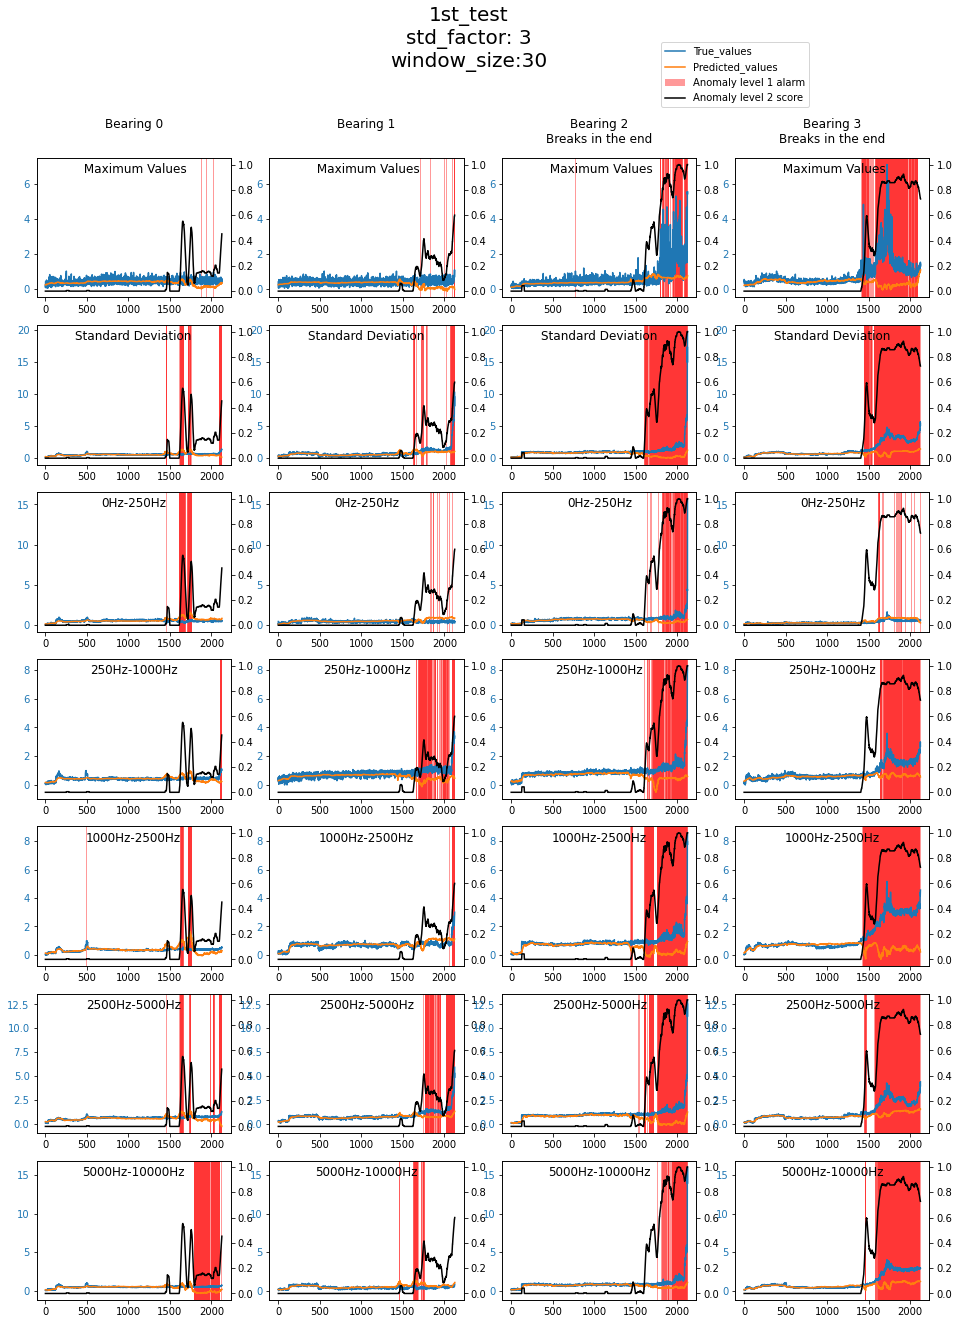

In [14]:
test=0
X = np.concatenate((X_train_series_sub[test],X_test_series_sub[test]))
y_true = np.concatenate((y_train[test],y_test[test]))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = evaluate(cnn_lstm, X, y_true, test_size ,test, slice_to_plot=np.s_[:],anomaly_1_factor=3, window_size=30,
show_y_pred=True, show_anomaly1 = True, show_anomaly2 = True)

1/1 [==============================] - 0s 241ms/step


Generating sequences: 100%|#######################################| 30/30 [00:00<00:00, 9995.96it/s]

2nd level alarm over 0.5:
[694 695 696 697 698 699 700 701 702 703]
[833 834 835 836 837 838 839 840 841 842]
[880 881 882 883 884 885 886 887 888 889]
[811 812 813 814 815 816 817 818 819 820]
Plotting


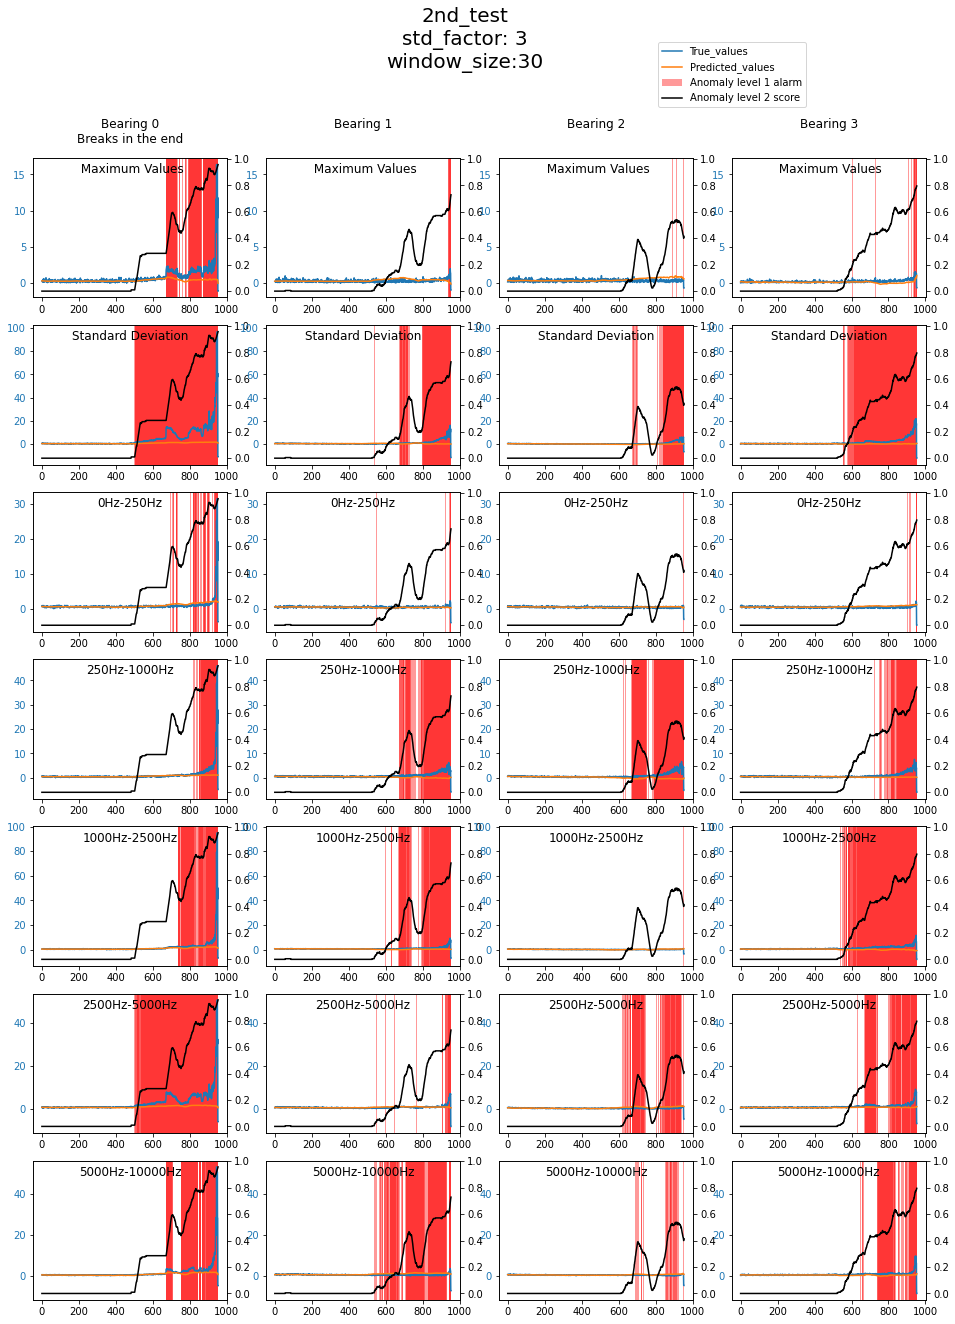

In [15]:
test=1
X = np.concatenate((X_train_series_sub[test],X_test_series_sub[test]))
y_true = np.concatenate((y_train[test],y_test[test]))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = evaluate(cnn_lstm, X, y_true, test_size ,test, slice_to_plot=np.s_[:],anomaly_1_factor=3, window_size=30,
show_y_pred=True, show_anomaly1 = True, show_anomaly2 = True)

1/1 [==============================] - 0s 308ms/step


Generating sequences: 100%|#######################################| 30/30 [00:00<00:00, 1199.85it/s]

2nd level alarm over 0.5:
[6153 6154 6155 6156 6157 6158 6159 6160 6161 6162]
[6207 6208 6209 6210 6211 6212 6213 6214 6215 6216]
[5956 5957 5958 5959 5960 5961 5962 5963 5964 5965]
[6224 6225 6226 6227 6228 6229 6230 6231 6232 6233]
Plotting


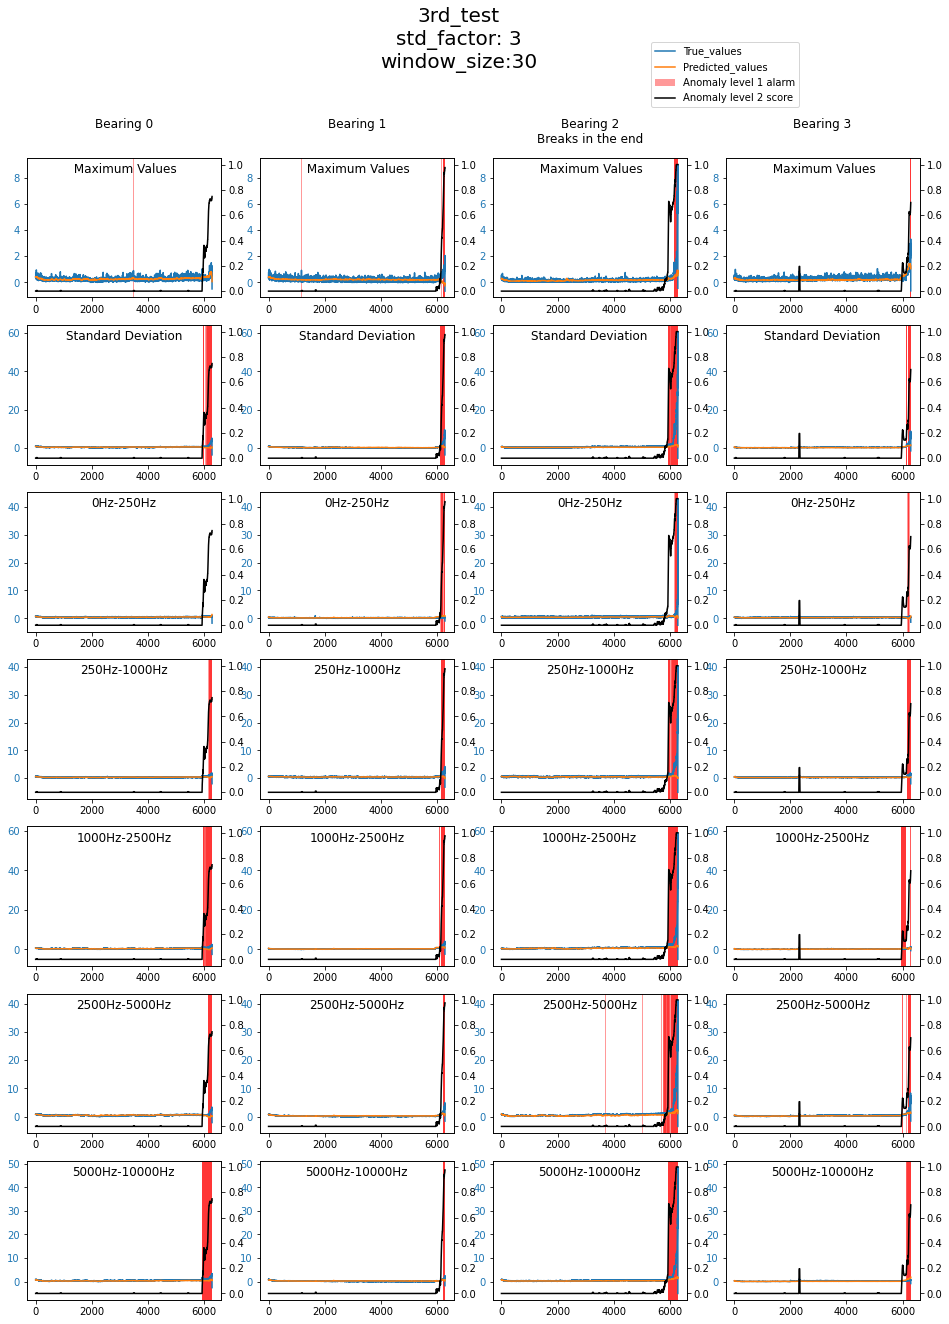

In [16]:
test=2
X = np.concatenate((X_train_series_sub[test],X_test_series_sub[test]))
y_true = np.concatenate((y_train[test],y_test[test]))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = evaluate(cnn_lstm, X, y_true, test_size ,test, slice_to_plot=np.s_[:],anomaly_1_factor=3, window_size=30,
show_y_pred=True, show_anomaly1 = True, show_anomaly2 = True)

In [17]:
cnn_lstm.save("model_cnn_lstm.h5")